In [1]:
import matplotlib
matplotlib.use('nbAgg')
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt


In [2]:
logdir = "/home/lindzey/remus_logs/"
mission = "mission255"


In [4]:
gtd_fields = ["timestamp",
          "mems1_c1", "mems1_c2", "mems1_c3", "mems1_c4", "mems1_c5", "mems1_c6", "mems1_raw_temp", "mems1_raw_pressure", "mems1_temp", "mems1_pressure", "unused0",
          "mems2_c1", "mems2_c2", "mems2_c3", "mems2_c4", "mems2_c5", "mems2_c6", "mems2_raw_temp", "mems2_raw_pressure", "mems2_temp", "mems2_pressure", 
          "v1", "supply_voltage", "unused1", "unused2", "unused3"]
gtd_field_idxs = {field: idx for idx, field in enumerate(gtd_fields)}
gtd_field_idxs

{'timestamp': 0,
 'mems1_c1': 1,
 'mems1_c2': 2,
 'mems1_c3': 3,
 'mems1_c4': 4,
 'mems1_c5': 5,
 'mems1_c6': 6,
 'mems1_raw_temp': 7,
 'mems1_raw_pressure': 8,
 'mems1_temp': 9,
 'mems1_pressure': 10,
 'unused0': 11,
 'mems2_c1': 12,
 'mems2_c2': 13,
 'mems2_c3': 14,
 'mems2_c4': 15,
 'mems2_c5': 16,
 'mems2_c6': 17,
 'mems2_raw_temp': 18,
 'mems2_raw_pressure': 19,
 'mems2_temp': 20,
 'mems2_pressure': 21,
 'v1': 22,
 'supply_voltage': 23,
 'unused1': 24,
 'unused2': 25,
 'unused3': 26}

In [10]:
def load_gtd(logdir, mission):
    gtd_datafile = os.path.join(logdir, mission, "extracted", f"{mission}_prooceanus_gtd.txt")
    count = 0
    gtd_data = []
    for line in open(gtd_datafile, 'r'):
        if '#' in line:
            print(line)
            continue
        tokens = line.split(',')
        if len(tokens) != 28:
            #print(line)
            continue

        info = tokens[0]
        tt = float(info.split(' ')[0])

        values = list(map(float, tokens[2:]))
        values.insert(0, tt)
        gtd_data.append(values)
               
    gtd_data = np.array(gtd_data)
    return gtd_data
    

In [6]:
def load_sbe43(logdir, mission):
    datafile = os.path.join(logdir, mission, "extracted", f"{mission}_sbe43_dissolved_oxygen.txt")
    data = []
    for line in open(datafile, 'r'):
        if '#' in line:
            print(line)
            continue
        tokens = line.split(' ')
        values = list(map(float, tokens))
        data.append(values)
    data = np.array(data)
    return data

    

In [7]:
def load_bme280(logdir, mission):
    datafile = os.path.join(logdir, mission, "extracted", f"{mission}_bme280_htp.txt")
    data = []
    for line in open(datafile, 'r'):
        if '#' in line:
            print(line)
            continue
        tokens = line.split(' ')
        values = list(map(float, tokens))
        data.append(values)
    data = np.array(data)
    return data



In [17]:
def load_ctd(logdir, mission):
    datafile = os.path.join(logdir, mission, "extracted", f"{mission}_recon_ctd.txt")
    data = []
    for line in open(datafile, 'r'):
        if '#' in line:
            print(line)
            continue
        tokens = line.split(' ')
        values = list(map(float, tokens))
        data.append(values)
    data = np.array(data)
    return data


In [8]:
# ros_time latitude longitude depth_m thruster_rpm mode
def load_recon(logdir, mission):
    datafile = os.path.join(logdir, mission, "extracted", f"{mission}_recon_state.txt")
    data = []
    for line in open(datafile, 'r'):
        if '#' in line:
            print(line)
            continue
        tokens = line.split(' ')
        values = list(map(float, tokens))
        data.append(values)
    data = np.array(data)
    return data



In [46]:
gtd_data = load_gtd(logdir, mission)
oxygen_data = load_sbe43(logdir, mission)
htp_data = load_bme280(logdir, mission)
ctd_data = load_ctd(logdir, mission)
remus_data = load_recon(logdir, mission)

# ros_time raw_data_string

# ros_time dissolved_oxygen_mL_L

# ros_time percent_humidity temperature_C pressure_Pa

# ros_time conductivity temperature pressure salinity sound_speed

# ros_time latitude longitude depth_m thruster_rpm mode heading



In [12]:
plt.plot(remus_data[:,3])

In [14]:
def interpolate_depth(posix_times, remus_data):
    remus_depth_idx = 3
    dd = np.interp(posix_times, remus_data[:,0], remus_data[:,remus_depth_idx])
    return dd

In [64]:
# plot science values as a function of depth
def plot_data_depth(logdir, mission):
    #gtd_data = load_gtd(logdir, mission)
    #oxygen_data = load_sbe43(logdir, mission)
    #htp_data = load_bme280(logdir, mission)
    #ctd_data = load_ctd(logdir, mission)
    #remus_data = load_recon(logdir, mission)
    
    fig = plt.figure(figsize=(15, 10))
    gtd_ax, ctd_ax, oxy_ax = fig.subplots(1,3)

    gtd_depth = interpolate_depth(gtd_data[:,0], remus_data) 
    gtd1_idx = gtd_field_idxs["mems1_pressure"]
    gtd2_idx = gtd_field_idxs["mems2_pressure"]

    gtd_ax.plot(gtd_data[:,gtd1_idx], gtd_depth, 'k.', label='mems1')
    gtd_ax.plot(gtd_data[:,gtd2_idx], gtd_depth, 'r.', label='mems2')
    gtd_ax.set_xlabel("GTD MEMS pressure (mbar)")
    gtd_ax.set_ylabel("Depth from Recon (m)")
    gtd_ax.legend()

    oxy_depth = interpolate_depth(oxygen_data[:,0], remus_data)
    oxy_im = oxy_ax.scatter(oxygen_data[:,1], oxy_depth, c=oxygen_data[:,0], s=10, ec="none")
    oxy_ax.set_xlabel('Oxygen Concentration (mL/L)')
    oxy_ax.set_ylabel('Depth from Recon (m)')
    oxy_cbar = fig.colorbar(oxy_im, ax=oxy_ax, label="time (s)")

    ctd_depth = interpolate_depth(ctd_data[:,0], remus_data) 
    cond_idx = 1
    temp_idx = 2
    pressure_idx = 3
    ctd_ax.plot(ctd_data[:,temp_idx], ctd_depth, 'k.', markersize=2, label="Temperature")
    set_ax_color(ctd_ax, 'black', 'x')
    ctd_ax2 = ctd_ax.twiny()
    ctd_ax2.plot(ctd_data[:,cond_idx], ctd_depth, 'r.', markersize=2, label="Conductivity")
    set_ax_color(ctd_ax2, 'red', 'x')
    #ctd_ax3 = ctd_ax.twiny()
    #ctd_ax3.plot(ctd_data[:,pressure_idx], ctd_depth, 'g.', label="Pressure")
    ctd_ax.set_xlabel("Temperature (C) from Recon")
    ctd_ax2.set_xlabel("Conductivity from Recon")
    #ctd_ax3.set_xlabel("Pressure from Recon")

    ctd_ax.set_ylabel("Depth from Recon (m)")

    fig.suptitle(mission)

    for ax in [gtd_ax, oxy_ax, ctd_ax]:
        ylim = ax.get_ylim()
        ax.set_ylim((ylim[1], ylim[0]))

    fig.savefig(f"{mission}_depth_plots.png", dpi=300)



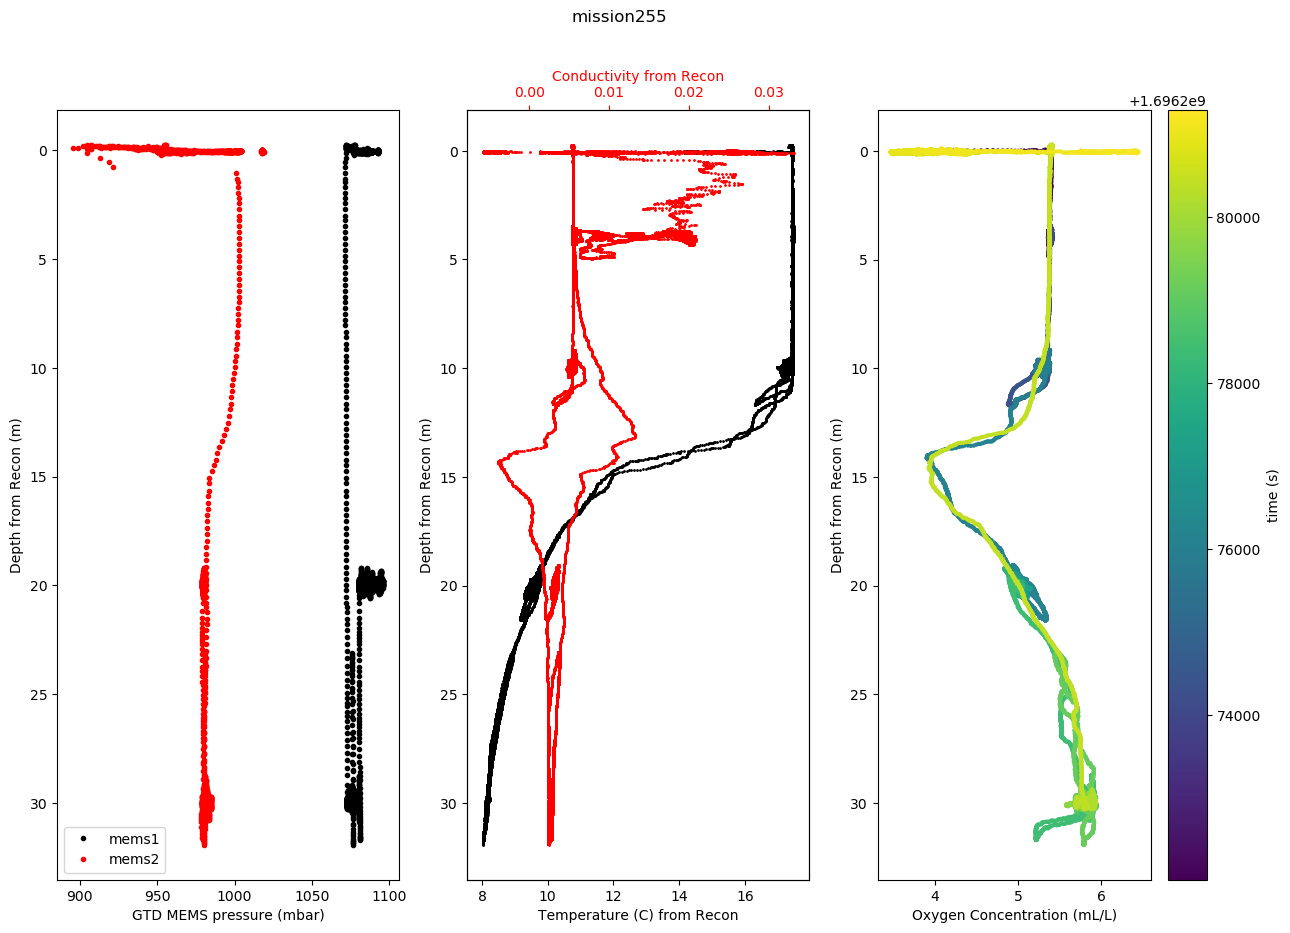

In [65]:
plot_data_depth(logdir, mission)

In [73]:
import datetime
import matplotlib.ticker
from matplotlib.ticker import FuncFormatter
class TimeFormatter(matplotlib.ticker.Formatter):
    def __call__(val, pos=None):
        dt = datetime.datetime.fromtimestamp(val)
        ss = dt.strftime("%Y-%m-%d %H:%M:%S")
        return ss

In [74]:
def set_ax_color(ax, color, which):
    """Set axis label / ticks / legend to given color"""
    # TODO: I can't figure out how to get the tick labels to be colored.
    ax.tick_params(which='both', color=color, labelcolor=color)
    if which == 'x':
        ax.xaxis.label.set_color(color)
    else:
        ax.yaxis.label.set_color(color)

In [85]:
# plot science values as a function of depth
def plot_data_time(logdir, mission):
    #gtd_data = load_gtd(logdir, mission)
    #oxygen_data = load_sbe43(logdir, mission)
    #htp_data = load_bme280(logdir, mission)
    #ctd_data = load_ctd(logdir, mission)
    #remus_data = load_recon(logdir, mission)
    
    fig = plt.figure(figsize=(15, 10))
    state_ax, gtd_ax, ctd_ax, oxy_ax = fig.subplots(4, 1)

    state_ax.plot(remus_data[:,0], remus_data[:,3], 'k.', markersize=2)
    set_ax_color(state_ax, 'black', 'y')
    state_ax.set_ylabel("Vehicle Depth (m)")
    ylim = state_ax.get_ylim()
    state_ax.set_ylim([ylim[1], ylim[0]])
    state_ax2 = state_ax.twinx()
    state_ax2.plot(remus_data[:,0], remus_data[:, 6], 'r.', markersize=2)
    set_ax_color(state_ax2, 'red', 'y')
    state_ax2.set_ylabel("Vehicle Heading (deg)")
    state_ax.set_xlabel("Time")
    
    gtd1_idx = gtd_field_idxs["mems1_pressure"]
    gtd2_idx = gtd_field_idxs["mems2_pressure"]

    gtd_ax.plot(gtd_data[:,0], gtd_data[:,gtd1_idx], 'k.', markersize=2, label='mems1')
    gtd_ax.plot(gtd_data[:,0], gtd_data[:,gtd2_idx], 'r.', markersize=2, label='mems2')
    gtd_ax.set_ylabel("GTD pressure (mbar)")
    gtd_ax.set_xlabel("Time")
    gtd_ax.legend()

    oxy_ax.plot(oxygen_data[:,0], oxygen_data[:,1], 'k.', markersize=2)
    oxy_ax.set_ylabel('Oxygen Concentration (mL/L)')
    oxy_ax.set_xlabel('Time')

    cond_idx = 1
    temp_idx = 2
    pressure_idx = 3
    ctd_ax.plot(ctd_data[:,0], ctd_data[:,temp_idx], 'k.', markersize=2, label="Temperature")
    set_ax_color(ctd_ax, 'black', 'y')
    ctd_ax2 = ctd_ax.twinx()
    ctd_ax2.plot(ctd_data[:,0], ctd_data[:,cond_idx], 'r.', markersize=2, label="Conductivity")
    set_ax_color(ctd_ax2, 'red', 'y')
    # Seems that the Remus doesn't provide pressure
    #ctd_ax3 = ctd_ax.twinx()
    #ctd_ax3.plot(ctd_data[:,0], ctd_data[:,pressure_idx], 'g.', markersize=2, label="Pressure")
    ctd_ax.set_ylabel("Temperature (C) from Recon")
    ctd_ax2.set_ylabel("Conductivity from Recon")
    #ctd_ax3.set_ylabel("Pressure from Recon")

    ctd_ax.set_xlabel("Time")
    # ctd_ax.legend()

    fig.suptitle(mission)

    fig.savefig(f"{mission}_time_plots.png", dpi=300)

    for ax in [state_ax, gtd_ax, oxy_ax, ctd_ax]:
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: datetime.datetime.fromtimestamp(x).strftime("%Y-%m-%d %H:%M:%S")))



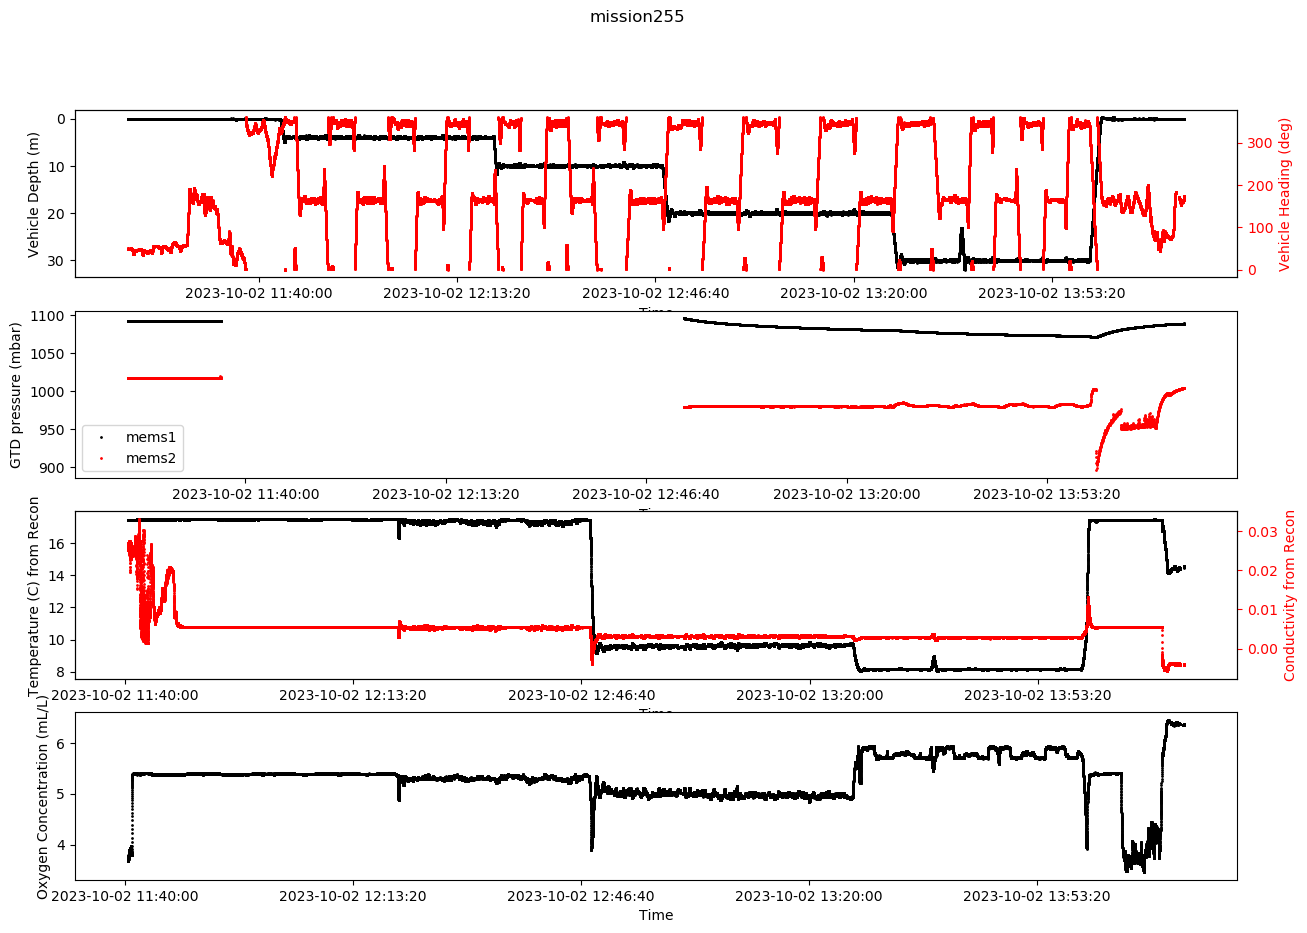

In [86]:
from matplotlib.ticker import FuncFormatter
plot_data_time(logdir, mission)

Text(0.5, 0, 'Time since start of mission (sec)')

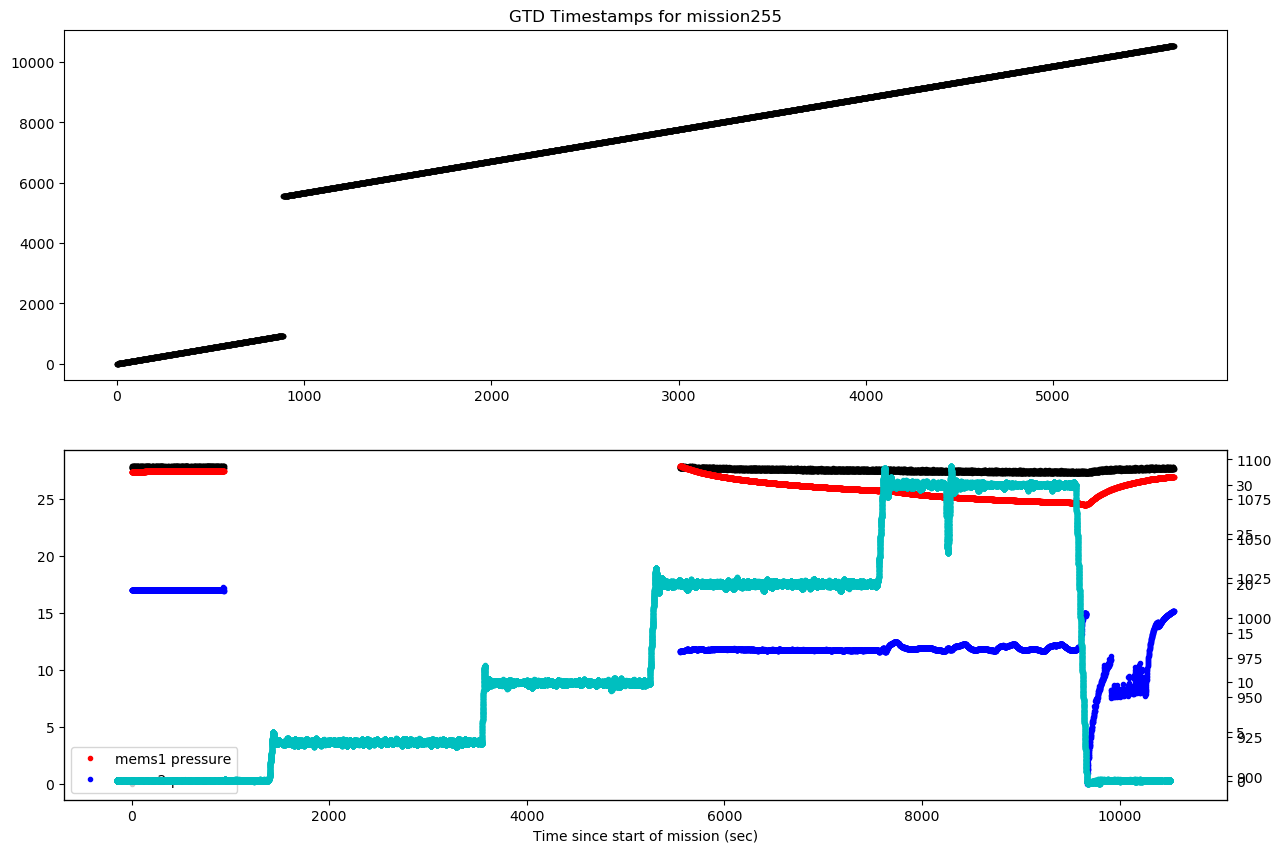

In [84]:
# Mission 255 had wonky data; look at that more closely
fig = plt.figure(figsize=(15,10))
ax1, ax2 = fig.subplots(2,1)
t0 = gtd_data[0,0]

ax1.plot(gtd_data[:,0]-t0, 'k.')
ax1.set_title(f"GTD Timestamps for {mission}")

ax2.plot(gtd_data[:,0]-t0, gtd_data[:,11], 'k.')
ax2b = ax2.twinx()
ax2b.plot(gtd_data[:,0]-t0, gtd_data[:,gtd_field_idxs["mems1_pressure"]], 'r.', label='mems1 pressure')
ax2b.plot(gtd_data[:,0]-t0, gtd_data[:,gtd_field_idxs["mems2_pressure"]], 'b.', label='mems2 pressure')
ax2b.legend()
ax2c = ax2.twinx()
ax2c.plot(remus_data[:,0] - t0, remus_data[:,3], 'c.')
ax2.set_xlabel('Time since start of mission (sec)')


In [58]:
gtd_data[1,:]

array([1.69627083e+09, 3.72390000e+04, 3.56560000e+04, 2.36810000e+04,
       2.24290000e+04, 3.05430000e+04, 2.83170000e+04, 7.68721600e+06,
       7.12312600e+06, 1.54702840e+01, 1.09209961e+03, 2.77750000e+01,
       3.76890000e+04, 3.73720000e+04, 2.41430000e+04, 2.38170000e+04,
       3.20930000e+04, 2.84900000e+04, 8.07445200e+06, 7.02227400e+06,
       1.51061190e+01, 1.01774341e+03, 2.78950000e+01, 1.17000000e+01,
       0.00000000e+00, 0.00000000e+00, 3.54719733e+09])

In [16]:
len(fields)

26

In [14]:
len(data[1])

26

{'mems1_c1': 0,
 'mems1_c2': 1,
 'mems1_c3': 2,
 'mems1_c4': 3,
 'mems1_c5': 4,
 'mems1_c6': 5,
 'mems1_raw_temp': 6,
 'mems1_raw_pressure': 7,
 'mems1_temp': 8,
 'mems1_pressure': 9,
 'mems2_c1': 10,
 'mems2_c2': 11,
 'mems2_c3': 12,
 'mems2_c4': 13,
 'mems2_c5': 14,
 'mems2_c6': 15,
 'mems2_raw_temp': 16,
 'mems2_raw_pressure': 17,
 'mems2_temp': 18,
 'mems2_pressure': 19,
 'v1': 20,
 'v2': 21,
 'supply_voltage': 22,
 'unused1': 23,
 'unused2': 24,
 'unused3': 25}